# Using minimizers and the parameter choice in model fitting

### Goals:

1. To continue fitting models of time-variability to the Vela pulsar data.
2. To understand how our choice of model parameter can affect the quality of the results.

### Timing

1. Try to finish this notebook in 35-40 minutes. 

### Question and Answer Template

You can go to the link below, and do "file" -> "make a copy" to make yourself a google doc that you can use to fill in the answers to the question in this weeks notebooks.

https://docs.google.com/document/d/1rKwI8zIhoj7zSRdIGAYcBkfRnCz1eIrEYE6lMJRqYkU/edit?usp=sharing

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

### New functions we will use in this module

| Function Name            | What it does |
| - | - |
| scipy.optimize.minimize  | Find the set of parameters that minimize a function |


### Ok let's pick up where we left off with the Vela pulsar data

(This cell is just a repeat of loading the Vela data)

In [3]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

# This is how we pull out the data from columns in the array.

# This is the date in "Mission Elapsed Time"
# For the Fermi mission, this is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]
# This is the offset in seconds between the Fermi "MET" and the UNIX "epoch" used by matplotlib
MET_To_Unix = 978336000

# These are the numbers of photons observed from Vela each week in the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

# These are the number of photons expected from Vela each week, under the assumption that it is 
# not varying at all, and the only differences depend on how long we spent looking at Vela
# that particular weeek
nExp_LE = data[:,2]

# These are the band bounds, in MeV
LE_bounds = (100., 800.)

# This is the "significance" of the variation for each week.  We will discuss this more later
signif_LE = data[:,3]

nObs_HE = data[:,4]
nExp_HE = data[:,5]
signif_HE = data[:6]
HE_bounds = (800., 10000.)

# This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]
date_YEAR = 2001 +  (date_MET / (24*3600*365))
years_since_mid_2014 = date_YEAR  - 2014.5

### Now let's add the functions we needed to minimize the $\chi^2$

That includes the model, a function to calculate the residuals and a function to compute the $\chi^2$.

These are exactly the same functions that we used last week.

In [4]:
def linear_function(xvals, params):
    return params[0] + xvals*params[1]

def residual_function(data_x, data_y, model_function, params):
    model_y = model_function(data_x, params)
    residual = data_y - model_y
    return residual

def chi2_function(data_x, data_y, data_sigma_y, model_function, params):
    model_y = model_function(data_x, params)
    chi2 = ((data_y - model_y)/(data_sigma_y))**2
    return np.sum(chi2)

# Function minimizers

Finding the set of parameters that minimize a function is a very common thing to do in research. In our case, we are looking for the set of model parameters that give us the smallest $\chi^2$, i.e., the best fit.

Last week, we did this by hand by varying two parameters in a linear model and calculating the $\chi^2$ for each set of values. 

Since this is such a common thing to do, there are many software packages that will do it.  Typically they refer to the function that is being minimized as the "cost function", and they expect you to provide a function that takes only the model parameters as inputs.

So we are going to write a "cost function" that just calls our $\chi^2$ with the right versions of the data and model.  

Because the software we use (`scipy.optimize`) has a slightly different convention than what we are using, we will multiply the $\chi^2$ by a factor of 0.5 so that the uncertainty estimated returned by the minimizer will be correct.  

In [5]:
excess_counts = nObs_LE-nExp_LE
sigma_counts =  np.sqrt(nObs_LE)

def cost_function(params):
    return 0.5*chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, params)

### Invoking the minimizer and looking at the result

First we are going to invoke the minimizer in the next cell.

It is worth spending a bit of time thinking about what it is doing.

Note that we pass three things to the minimizer:
   1. the `cost_function` (you might not have explicitly noticed this before, but we can pass functions to other functions)
   2. an initial guess as to the parameter values.  In this case we will start with (0., 0.), i.e., slope and offset are both zero.
   3. The method of minimization. There are many algorithms that have been developed to minimize functions. Here we choose one of the speedier algorithms, but you can specify different algorithms (see [scipy reference](https://docs.scipy.org/doc/scipy/reference/optimize.html)).
   
And note that the minimizer returns a `result` to us, which we will explore in the second cell.

In [6]:
result = optimize.minimize(cost_function, x0=[0., 0.])

In [7]:
result = optimize.minimize(cost_function, [0., 0.], method="BFGS")
pars = result['x']
fmin = result['fun']
p0_best = pars[0]
p1_best = pars[1]
cov = result['hess_inv']
p0_err = np.sqrt(cov[0,0])
p1_err = np.sqrt(cov[1,1])
correl = cov[1,0]/np.sqrt(p0_err*p1_err)

print("Fitter result:")
print(result)

print("")
print("Human readable version ---------------")
print(f"  p0 best fit value: {p0_best:.1f} ± {p0_err:.1f} counts")
print(f"  p1 best fit value: {p1_best:.1f} ± {p1_err:.1f} counts / year")
print(f"  Minimum value of cost function: {fmin:.1f}")
print(f"  Minimum value of chi**2: {(2*fmin):.1f}")
print(f"  Correlation between p0 and p1: {correl:.2f}")
print(f"  Number of times cost function was evaluated to find minimum: {result['nfev']}")


Fitter result:
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 382.2254022807482
        x: [-1.712e+00  1.288e-01]
      nit: 5
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 4.361e+00 -6.324e-02]
            [-6.324e-02  3.371e-01]]
     nfev: 18
     njev: 6

Human readable version ---------------
  p0 best fit value: -1.7 ± 2.1 counts
  p1 best fit value: 0.1 ± 0.6 counts / year
  Minimum value of cost function: 382.2
  Minimum value of chi**2: 764.5
  Correlation between p0 and p1: -0.06
  Number of times cost function was evaluated to find minimum: 18


### Ok, now let's draw the fit result on top of the contours we made last week

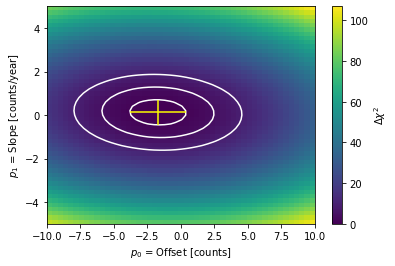

In [8]:
plt.xlabel(r"$p_0$ = Offset [counts]")
plt.ylabel(r"$p_1$ = Slope [counts/year]")


nx = 51
ny = 51

params = np.array([0., 0.])
chi2_2d_scan_vals = np.zeros((nx, ny))
offset_scan_points = np.linspace(-10., 10., nx)
slope_scan_points = np.linspace(-5., 5., ny)

# Double loop for 2d scan
for i in range(nx):
    params[0] = offset_scan_points[i]
    for j in range(ny):
        params[1] = slope_scan_points[j]
        chi2_2d_scan_vals[i,j] = chi2_function(years_since_mid_2014, excess_counts, sigma_counts,
                                               linear_function, params)

min_chi2 = chi2_2d_scan_vals.min()
chi2_2d_scan_vals -= min_chi2

# Now let's plot it.
plt.imshow(chi2_2d_scan_vals.T, extent=(-10, 10, -5, 5), aspect='auto', origin='lower')
plt.colorbar(label=r"$\Delta \chi^2$")
plt.contour(offset_scan_points, slope_scan_points, chi2_2d_scan_vals.T, levels=[1, 4, 9], colors="white")
plt.errorbar(p0_best, p1_best, xerr=p0_err, yerr=p1_err, color='yellow')
plt.show()

### Questions for discusion

#### 1.1  Let's make sure that you understand what we have done so far. Describe in some detail the relationship between the colormap, the white contours and the yellow error bars. What does each thing represent? How do they correspond to the information in the "human readable" printout of the result?  (Note that this is the same colormap that we made at the end of last week's second notebook when we did the two dimensional scan over the parameter values.)

#### 1.2 To make the colormap we had to do a double loop over a grid of points for the parameters $p_0$ and $p_1$. The grid was 51x51, for a total of 2601 points, meaning we had to evaluate the cost function 2601 times. In this example we only had 2 parameters; imagine instead that we had 3 or 4 parameters. How would that affect the time it took to evaluate the cost function on a grid over all the parameters? Compare that to the number of calls that the fitter makes in order to find the minimum.

### Reproducibility

Let's play around with the fitter and try it with 20 different initial guesses and compare the results and the number of calls to the cost function it takes.

In [9]:
for i in range(20):
    x0 = [np.random.uniform(-10, 10), np.random.uniform(-5, 5)]
    result = optimize.minimize(cost_function, x0=x0)
    best_fit = result['x']
    print(f"Initial guess: ({x0[0]:.2f} {x0[1]:.2f}): found fit result: ({best_fit[0]:.6f} {best_fit[1]:.6f}) after {result['nfev']} calls to the cost function")

Initial guess: (-9.47 -4.79): found fit result: (-1.711790 0.128826) after 30 calls to the cost function
Initial guess: (-5.01 0.42): found fit result: (-1.711765 0.128830) after 21 calls to the cost function
Initial guess: (-6.93 1.29): found fit result: (-1.711756 0.128829) after 24 calls to the cost function
Initial guess: (7.08 3.48): found fit result: (-1.711776 0.128831) after 30 calls to the cost function
Initial guess: (-8.33 -2.93): found fit result: (-1.711766 0.128826) after 27 calls to the cost function
Initial guess: (6.13 2.68): found fit result: (-1.711758 0.128829) after 27 calls to the cost function
Initial guess: (-4.43 0.80): found fit result: (-1.711764 0.128827) after 27 calls to the cost function
Initial guess: (0.93 3.09): found fit result: (-1.711801 0.128828) after 24 calls to the cost function
Initial guess: (-8.78 -3.24): found fit result: (-1.711761 0.128826) after 30 calls to the cost function
Initial guess: (-1.10 -3.38): found fit result: (-1.711791 0.128

### Question for discussion

#### 2.1 The results for the 20 trials are very similar but not quite identical. Does this make sense to you? Do you have an idea about why the results aren't identical? How do you think the fitter decides that it is done? (Don't worry if you don't know the answer, just have a guess.)

# Correlation between model parameters

In last week's notebook, you may have noted that we set t=0 to be in the middle of 2014, which might seem arbitrary. 

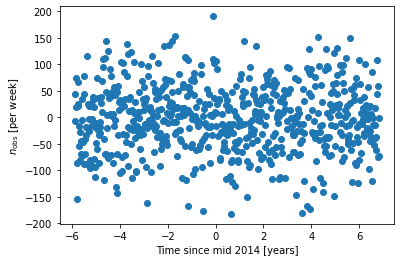

In [10]:
years_since_mid_2014 = date_YEAR  - 2014.5
excess_counts = nObs_LE-nExp_LE
plt.scatter(years_since_mid_2014, excess_counts)
plt.xlabel(r"Time since mid 2014 [years]")
plt.ylabel(r"$n_{\rm obs}$ [per week]")
plt.show()

There was actually a very good reason to do that, which we will examine now. 

The Fermi telescope actually launched in 2008, so we could set t=0 to be in January 2008.

In [11]:
years_since_2008 = date_YEAR  - 2008

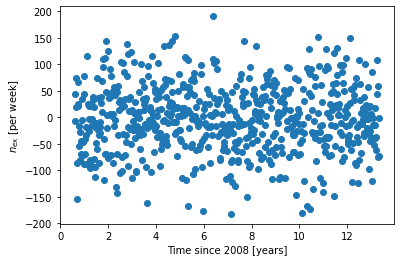

In [12]:
excess_counts = nObs_LE-nExp_LE
plt.scatter(years_since_2008, excess_counts)
plt.xlabel(r"Time since 2008 [years]")
plt.ylabel(r"$n_{\rm ex}$ [per week]")
plt.show()

Now, let's think about what happens to fitting our linear model when we make this change. 

Keep in mind that the model function we are using is a simple equation for a line: $y = p_0 + p_1 x$

By moving the zero point of the x-axis, we are changing how that function works with the data. The model parameters are now more *correlated*. To demonstrate this, we will make a plot for different values of $p_1$.

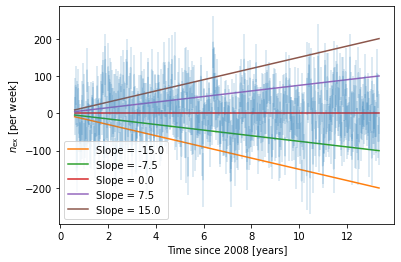

In [13]:
plt.xlabel(r"Time since 2008 [years]")
plt.ylabel(r"$n_{\rm ex}$ [per week]")
plt.errorbar(years_since_2008, excess_counts, yerr=sigma_counts, alpha=0.2)

xvals = years_since_2008
params = np.array([0., 0.])
for slope in np.linspace(-15, 15, 5):
    params[1] = slope
    plt.plot(xvals, linear_function(xvals, params), label=rf"Slope = {slope:0.1f}")
plt.legend()
plt.show()

As you can see, all the lines cross at t=0, which is now off the left side of the plot.  Before it was more or less in the middle of the plot.  

**What this means is that if you were to pick a value like, say, $p_1 = 7.5$ the model tends to be above the average of the data for the entire time.  This means that you would have to change the offset $p_0$ to a negative number to compensate.**

That is exactly what we mean when we say that the parameters have become more correlated. 

Let's explore this with the minimizer.

First we have to make a version of the cost function that uses this version of the x-axis data. 

In [14]:
def cost_function_bad(params):
    return 0.5*chi2_function(years_since_2008, excess_counts, sigma_counts, linear_function, params)

Now, let's minimize the cost function again to find the best fit parameters:

In [15]:
result_bad = optimize.minimize(cost_function_bad, [0., 0.])
pars_bad = result_bad['x']
fmin_bad = result_bad['fun']
p0_best_bad = pars_bad[0]
p1_best_bad = pars_bad[1]
cov_bad = result_bad['hess_inv']
p0_err_bad = np.sqrt(cov_bad[0,0])
p1_err_bad = np.sqrt(cov_bad[1,1])
correl_bad = cov_bad[1,0]/(p0_err_bad*p1_err_bad)

print("")
print("Human readable version: bad idea ---------------")
print(f"  Minimum value of cost function: {fmin_bad:.1f}")
print(f"  Minimum value of chi**2: {(2*fmin_bad):.1f}")
print(f"  p0 best fit: {p0_best_bad:.1f} ± {p0_err_bad:.1f} counts")
print(f"  p1 best fit: {p1_best_bad:.1f} ± {p1_err_bad:.1f} counts / year")
print(f"  Correlation between p0 and p1: {correl_bad:.2f}")


Human readable version: bad idea ---------------
  Minimum value of cost function: 382.2
  Minimum value of chi**2: 764.5
  p0 best fit: -2.5 ± 4.4 counts
  p1 best fit: 0.1 ± 0.6 counts / year
  Correlation between p0 and p1: -0.88


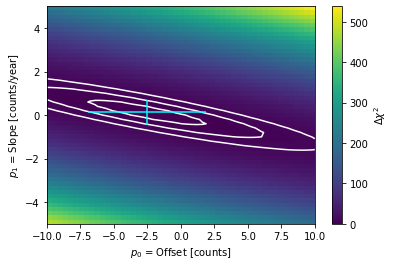

New best fit value is 764.5 for (-2.5 ± 4.4, 0.1 ± 0.6)
Original fit value was 764.5 for (-1.7 ± 2.1, 0.1 ± 0.6)
Original correlation was -0.06, now it is -0.88


In [16]:
plt.xlabel(r"$p_0$ = Offset [counts]")
plt.ylabel(r"$p_1$ = Slope [counts/year]")

chi2_2d_scan_vals_bad = np.zeros((nx, ny))
offset_scan_points = np.linspace(-10., 10., nx)
slope_scan_points = np.linspace(-5., 5., ny)

# Double loop for 2d scan
for i in range(nx):
    params[0] = offset_scan_points[i]
    for j in range(ny):
        params[1] = slope_scan_points[j]
        chi2_2d_scan_vals_bad[i,j] = chi2_function(years_since_2008, excess_counts, sigma_counts,
                                                   linear_function, params)

min_chi2_bad = chi2_2d_scan_vals_bad.min()
chi2_2d_scan_vals_bad -= min_chi2_bad

# Now let's plot it.
plt.imshow(chi2_2d_scan_vals_bad.T, extent=(-10, 10, -5, 5), aspect='auto', origin='lower')
plt.colorbar(label=r"$\Delta \chi^2$")
plt.contour(offset_scan_points, slope_scan_points, chi2_2d_scan_vals_bad.T, levels=[1, 4, 9], colors="white")
plt.errorbar(p0_best_bad, p1_best_bad, xerr=p0_err_bad, yerr=p1_err_bad, color='cyan')
#plt.errorbar(p0_best, p1_best, xerr=p0_err, yerr=p1_err, color='yellow')
plt.show()

print(f"New best fit value is {min_chi2_bad:0.1f} for ({p0_best_bad:0.1f} ± {p0_err_bad:0.1f}, {p1_best_bad:0.1f} ± {p1_err_bad:0.1f})")

print(f"Original fit value was {min_chi2:0.1f} for ({p0_best:0.1f} ± {p0_err:0.1f}, {p1_best:0.1f} ± {p1_err:0.1f})")

print(f"Original correlation was {correl:0.2f}, now it is {correl_bad:0.2f}")

### Questions for discussion

#### 3.1 What is going on in this plot?  Why are the contours tilted?  Why are the error bars larger?  

#### 3.2 What does this tell us about what we should consider when building models?